In [59]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
import pickle
import openmeteo_requests
from retry_requests import retry
import requests_cache

In [60]:
hotspots = gpd.read_file("./data_2024/hotspots/fire_archive_M-C61_629919.shp")
perimeter = gpd.read_file("./data_2024/perimeter/cc_apt_buf.shp")

# print(hotspots.head(3))
# print(perimeter.head(3))


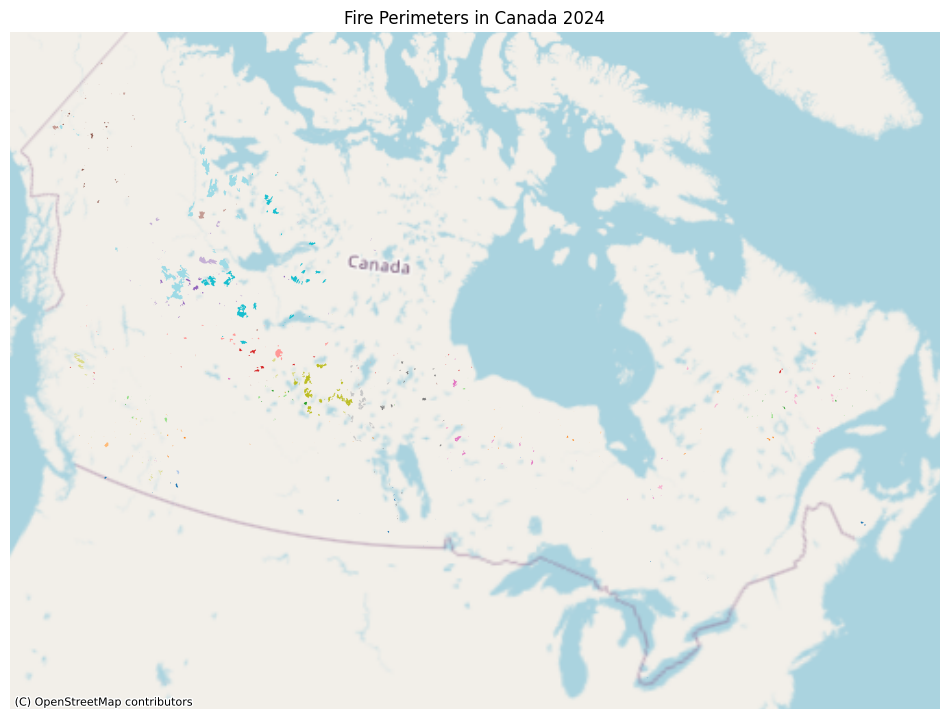

In [61]:
# Set + Match CRS for both files
if hotspots.crs is None:
    hotspots.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

if perimeter.crs is None:
    perimeter.set_crs(epsg=3978, inplace=True)  # NAD_1983_Canada_Atlas_Lambert

hotspots = hotspots.to_crs(perimeter.crs)

# Check intersections and join hotspots and perimeters into 1 dataframe
hotspots_with_perimeter = gpd.sjoin(hotspots, perimeter, how="inner", predicate="intersects")

# combined ACQ_TIME + ACQ_DATE
hotspots_with_perimeter['ACQ_TIME'] = hotspots_with_perimeter['ACQ_TIME'].astype(str).str.zfill(4)
hotspots_with_perimeter['ACQ_DATETIME'] = pd.to_datetime(
    hotspots_with_perimeter['ACQ_DATE'].astype(str) + ' ' +
    hotspots_with_perimeter['ACQ_TIME'].str[:2] + ':' +
    hotspots_with_perimeter['ACQ_TIME'].str[2:], 
    format='%Y-%m-%d %H:%M'
)

# Align hotspot aquired date, with the perimeter start + end dates
hotspots_with_perimeter = hotspots_with_perimeter[
    (hotspots_with_perimeter['ACQ_DATETIME'] >= hotspots_with_perimeter['FIRSTDATE']) &
    (hotspots_with_perimeter['ACQ_DATETIME'] <= hotspots_with_perimeter['LASTDATE'])
]

# print(hotspots_with_perimeter.head())

# Count number of fire points per polygon UID
counts = hotspots_with_perimeter.groupby("UID").size().reset_index(name="hotspot_count")

# add a hotspot_count column for keeping track of how many hotspots there are per fire
perimeter_with_counts = perimeter.merge(counts, on="UID", how="left")
perimeter_with_counts["hotspot_count"] = perimeter_with_counts["hotspot_count"].fillna(0).astype(int)

# Plot fire perimeters colored by UID
fig, ax = plt.subplots(figsize=(12, 12))
perimeter_with_counts.plot(
    ax=ax,
    column="UID",
    categorical=True,
    legend=False,
    cmap="tab20"
)
# set map as background
cx.add_basemap(ax, crs=perimeter_with_counts.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Fire Perimeters in Canada 2024")
ax.axis("off")
plt.show()

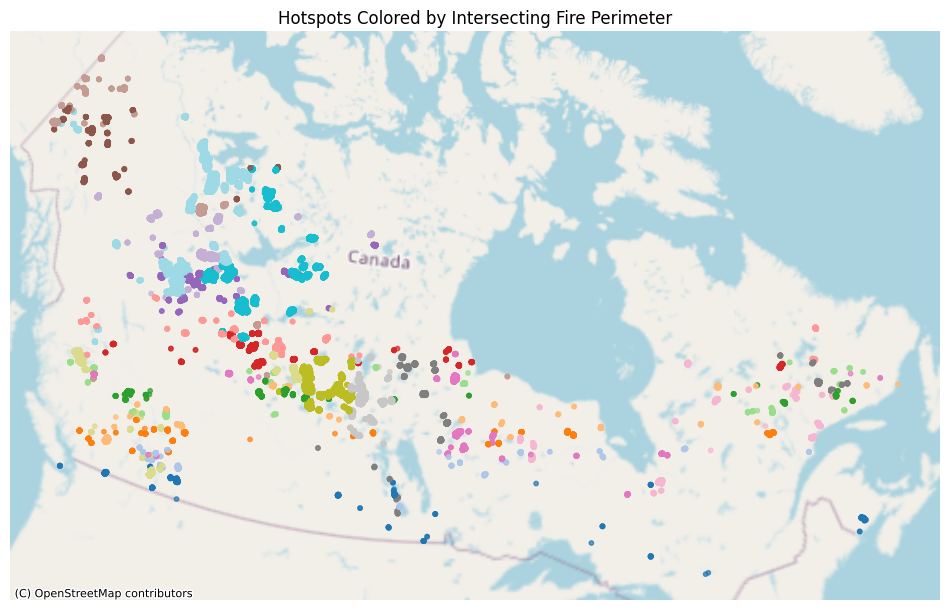

In [62]:
# Plot hotspot points, colored by respective fire groups (determined by intersection)
fig, ax = plt.subplots(figsize=(12, 12))

hotspots_with_perimeter.plot(
    ax=ax,
    column="UID",
    categorical=True,
    legend=False,
    cmap="tab20",
    markersize=10,
    alpha=0.7
)

ax.set_title("Hotspots Colored by Intersecting Fire Perimeter")
ax.axis("off")
cx.add_basemap(ax, crs=perimeter_with_counts.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.show()

In [63]:
training_data = hotspots_with_perimeter[['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'ACQ_DATE', 'ACQ_TIME', 
                                         'FRP', 'UID', 'HCOUNT', 'AREA', 'FIRSTDATE', 'LASTDATE']]

training_data = training_data[training_data['UID'].map(training_data['UID'].value_counts()) > 2]

grouped = training_data.groupby(['UID', 'ACQ_DATE'])

def max_and_min(g):
    max_lat_row = g.loc[g['LATITUDE'].idxmax()]
    min_lat_row = g.loc[g['LATITUDE'].idxmin()]
    max_lon_row = g.loc[g['LONGITUDE'].idxmax()]
    min_lon_row = g.loc[g['LONGITUDE'].idxmin()]
    
    return pd.Series({
        'LAT_MAX_LAT': max_lat_row['LATITUDE'],
        'LAT_MAX_LON': max_lat_row['LONGITUDE'],
        'LAT_MIN_LAT': min_lat_row['LATITUDE'],
        'LAT_MIN_LON': min_lat_row['LONGITUDE'],
        'LON_MAX_LAT': max_lon_row['LATITUDE'],
        'LON_MAX_LON': max_lon_row['LONGITUDE'],
        'LON_MIN_LAT': min_lon_row['LATITUDE'],
        'LON_MIN_LON': min_lon_row['LONGITUDE'],
        'ACQ_TIME_MAX_LAT': max_lat_row['ACQ_TIME'],
        'ACQ_TIME_MIN_LAT': min_lat_row['ACQ_TIME'],
        'ACQ_TIME_MAX_LON': max_lon_row['ACQ_TIME'],
        'ACQ_TIME_MIN_LON': min_lat_row['ACQ_TIME']
    })

training_data = grouped.apply(max_and_min).reset_index()

# add column for next lon/lat
training_data['NEXT_LAT_MAX_LAT'] = training_data.groupby('UID')['LAT_MAX_LAT'].shift(-1)
training_data['NEXT_LAT_MAX_LON'] = training_data.groupby('UID')['LAT_MAX_LON'].shift(-1)
training_data['NEXT_LAT_MIN_LAT'] = training_data.groupby('UID')['LAT_MIN_LAT'].shift(-1)
training_data['NEXT_LAT_MIN_LON'] = training_data.groupby('UID')['LAT_MIN_LON'].shift(-1)
training_data['NEXT_LON_MAX_LAT'] = training_data.groupby('UID')['LON_MAX_LAT'].shift(-1)
training_data['NEXT_LON_MAX_LON'] = training_data.groupby('UID')['LON_MAX_LON'].shift(-1)
training_data['NEXT_LON_MIN_LAT'] = training_data.groupby('UID')['LON_MIN_LAT'].shift(-1)
training_data['NEXT_LON_MIN_LON'] = training_data.groupby('UID')['LON_MIN_LON'].shift(-1)
training_data = training_data.dropna(subset=['NEXT_LAT_MAX_LAT', 'NEXT_LAT_MAX_LON', 
                                             'NEXT_LAT_MIN_LAT', 'NEXT_LAT_MIN_LON',
                                             'NEXT_LON_MAX_LAT', 'NEXT_LON_MAX_LON',
                                             'NEXT_LON_MIN_LAT', 'NEXT_LON_MIN_LON'])

C:\Users\alexx\AppData\Local\Temp\ipykernel_25588\1595593627.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  training_data = grouped.apply(max_and_min).reset_index()


In [64]:
# Add weather data to table
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

points = ['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN']
weather_features = ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'wind_direction_10m', 'precipitation']
weather_columns = [f"{pt}_{feat}" for pt in points for feat in weather_features]

# add new columns to training_data
for col in weather_columns:
    training_data[col] = None

for index, row in training_data.iterrows():
    lat_list = [row.get(f"{pt}_LAT") for pt in points]
    lon_list = [row.get(f"{pt}_LON") for pt in points]
    date = pd.to_datetime(row["ACQ_DATE"]).strftime("%Y-%m-%d")

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_list,
        "longitude": lon_list,
        "start_date": [date, date, date, date],
        "end_date": [date, date, date, date],
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
        "timezone": ["GMT", "GMT", "GMT", "GMT"]
    }
    response = openmeteo.weather_api(url, params=params)

    acq_time_map = {
        "LAT_MAX": "ACQ_TIME_MAX_LAT",
        "LAT_MIN": "ACQ_TIME_MIN_LAT",
        "LON_MAX": "ACQ_TIME_MAX_LON",
        "LON_MIN": "ACQ_TIME_MIN_LON"
    }

    for i, point in enumerate(points):
        weather_data = response[i].Hourly()
        acq_col = acq_time_map[point]
        current_time = int(str(row[acq_col]).zfill(4)[:2])

        values = {
            "temperature_2m" : weather_data.Variables(0).ValuesAsNumpy()[current_time],
            "relative_humidity_2m" : weather_data.Variables(1).ValuesAsNumpy()[current_time],
            "wind_speed_10m" : weather_data.Variables(2).ValuesAsNumpy()[current_time],
            "wind_direction_10m" : weather_data.Variables(3).ValuesAsNumpy()[current_time],
            "precipitation" : weather_data.Variables(4).ValuesAsNumpy()[current_time]
        }

        for stat, val in values.items():
            training_data.at[index, f"{point}_{stat}"] = val

print(training_data.head())


        UID   ACQ_DATE  LAT_MAX_LAT  LAT_MAX_LON  LAT_MIN_LAT  LAT_MIN_LON  \
0  32267271 2024-08-05      47.3180     -80.8734      47.3180     -80.8734   
1  32267271 2024-08-09      47.3432     -80.8781      47.3332     -80.8737   
3  32267297 2024-05-13      49.1239     -96.8370      49.1239     -96.8370   
4  32267297 2024-07-11      49.1201     -96.8333      49.1201     -96.8333   
5  32267297 2024-07-30      49.1196     -96.8336      49.1177     -96.8471   

   LON_MAX_LAT  LON_MAX_LON  LON_MIN_LAT  LON_MIN_LON  ...  \
0      47.3180     -80.8734      47.3180     -80.8734  ...   
1      47.3367     -80.8562      47.3432     -80.8781  ...   
3      49.1239     -96.8370      49.1239     -96.8370  ...   
4      49.1201     -96.8333      49.1201     -96.8333  ...   
5      49.1196     -96.8336      49.1177     -96.8471  ...   

  LON_MAX_temperature_2m LON_MAX_relative_humidity_2m LON_MAX_wind_speed_10m  \
0                21.9555                    37.012165              12.313894  

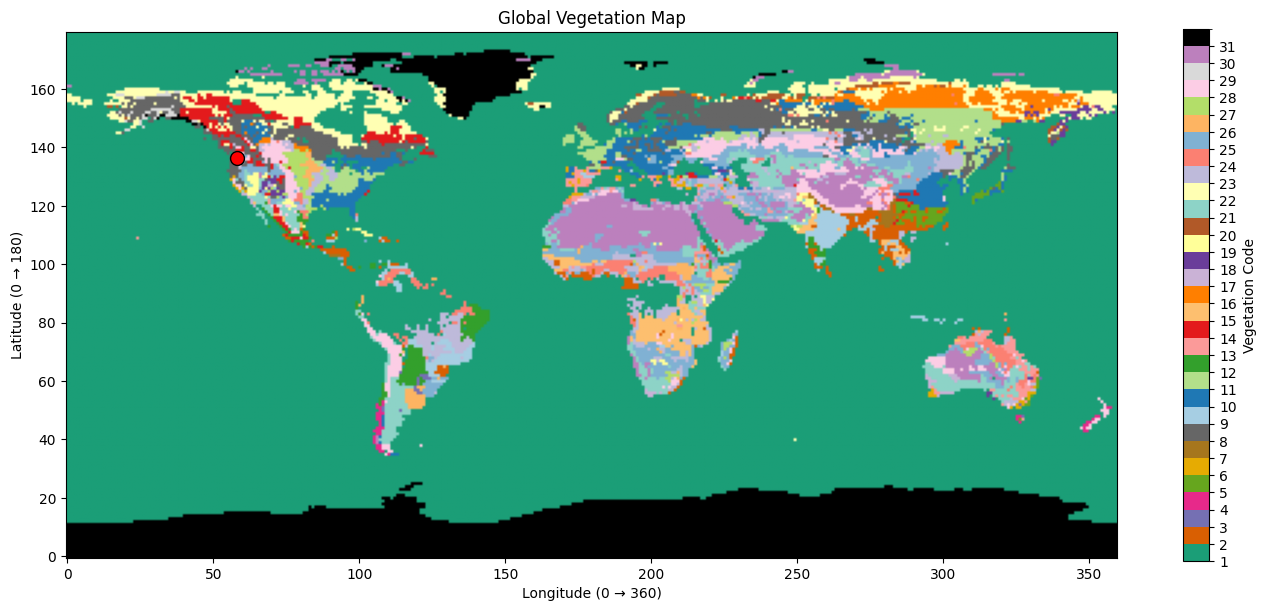

In [65]:
# Get vegetation data
with open("./data_2024/Vegetation.txt", 'r') as f:
    lines = f.readlines()

data = []

# skip top 3 rows since it is text
for line in lines:
    try:
        nums = [int(val) for val in line.strip().split()]
        data.extend(nums)
    except ValueError:
        continue

# Convert list to 2D array with 180 x 360 dimensions
veg_array = np.array(data[:180*360]).reshape((180, 360))

from matplotlib.colors import ListedColormap, BoundaryNorm

colors = [
    "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e",  # 1–5
    "#e6ab02", "#a6761d", "#666666", "#a6cee3", "#1f78b4",  # 6–10
    "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f",  # 11–15
    "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928",  # 16–20
    "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3",  # 21–25
    "#fdb462", "#b3de69", "#fccde5", "#d9d9d9", "#bc80bd",  # 26–30
    "#000000"  # 31 = Water/Ocean
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(1, 33), cmap.N)

# Plot out vegetation map
plt.figure(figsize=(14, 6))
plt.imshow(veg_array, cmap=cmap, norm=norm, origin='lower')
plt.title("Global Vegetation Map")
plt.xlabel("Longitude (0 → 360)")
plt.ylabel("Latitude (0 → 180)")
cbar = plt.colorbar(ticks=np.arange(1, 32))
cbar.set_label("Vegetation Code")
plt.tight_layout()
# POINT AT (47, -122)
plt.scatter(-122+180, 47+89.5 , color='red', s=100, edgecolors='black', marker='o', label='Target Point')
plt.show()

In [66]:
# Adding vegetation data to training_data
cords = ['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN']

veg_points = ['LAT_MAX_VEG', 'LAT_MIN_VEG', 'LON_MAX_VEG', 'LON_MIN_VEG']

for col in veg_points:
    training_data[col] = None

for index, row in training_data.iterrows():
    for cord in cords:
        lat = row.get(f"{cord}_LAT")
        lon = row.get(f"{cord}_LON")

        convertedLat = int(lat+89.5)   
        convertedLon = int(lon+180)   

        veg_type = veg_array[convertedLat, convertedLon]

        training_data.at[index, f"{cord}_VEG"] = veg_type

print(training_data.iloc[1234])

UID                                        32268907
ACQ_DATE                        2024-08-07 00:00:00
LAT_MAX_LAT                                 61.0847
LAT_MAX_LON                               -126.4386
LAT_MIN_LAT                                 61.0675
LAT_MIN_LON                               -126.4029
LON_MAX_LAT                                 61.0695
LON_MAX_LON                                -126.389
LON_MIN_LAT                                 61.0847
LON_MIN_LON                               -126.4386
ACQ_TIME_MAX_LAT                               2018
ACQ_TIME_MIN_LAT                               2040
ACQ_TIME_MAX_LON                               2018
ACQ_TIME_MIN_LON                               2040
NEXT_LAT_MAX_LAT                            61.1005
NEXT_LAT_MAX_LON                          -126.3884
NEXT_LAT_MIN_LAT                            61.0649
NEXT_LAT_MIN_LON                          -126.3933
NEXT_LON_MAX_LAT                            61.0835
NEXT_LON_MAX

In [67]:

feature_cols = ['LAT_MAX_LAT', 'LAT_MAX_LON', 'LAT_MIN_LAT', 'LAT_MIN_LON', 'LON_MAX_LAT', 'LON_MAX_LON', 'LON_MIN_LAT', 'LON_MIN_LON']
X = training_data[feature_cols]
y = training_data[['NEXT_LAT_MAX_LAT', 'NEXT_LAT_MAX_LON', 'NEXT_LAT_MIN_LAT', 'NEXT_LAT_MIN_LON',
                   'NEXT_LON_MAX_LAT', 'NEXT_LON_MAX_LON', 'NEXT_LON_MIN_LAT', 'NEXT_LON_MIN_LON']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# # Evaluate RMSE for each output
# for i, col in enumerate(y.columns):
#     rmse = root_mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
#     print(f"RMSE for {col}: {rmse:.4f}")

# #PREDICTION TEST HERE ______________________________________________________________________________________
# uid_value = 32269507 # this has the largest amount of hotspots
# matching_rows = training_data[training_data['UID'] == uid_value]
# # print(matching_rows)

# feature_cols = ['LAT_MAX_LAT', 'LAT_MAX_LON', 'LAT_MIN_LAT', 'LAT_MIN_LON', 'LON_MAX_LAT', 'LON_MAX_LON', 'LON_MIN_LAT', 'LON_MIN_LON']
# X_uid = matching_rows[feature_cols]

# # Predict next day max + min, lat + lon
# y_pred = model.predict(X_uid)

# # Add predicted columns to DataFrame
# matching_rows['PRED_NEXT_LAT_MAX_LAT'] = y_pred[:, 0]
# matching_rows['PRED_NEXT_LAT_MAX_LON'] = y_pred[:, 1]
# matching_rows['PRED_NEXT_LAT_MIN_LAT'] = y_pred[:, 2]
# matching_rows['PRED_NEXT_LAT_MIN_LON'] = y_pred[:, 3]
# matching_rows['PRED_NEXT_LON_MAX_LAT'] = y_pred[:, 4]
# matching_rows['PRED_NEXT_LON_MAX_LON'] = y_pred[:, 5]
# matching_rows['PRED_NEXT_LON_MIN_LAT'] = y_pred[:, 6]
# matching_rows['PRED_NEXT_LON_MIN_LON'] = y_pred[:, 7]

# print(matching_rows.head())


In [68]:
# pickle.dump(model, open("spread_model.pkl", "wb"))